<a href="https://colab.research.google.com/github/m-costantini/Set-wise_Coordinate_Descent/blob/master/main_iters_vs_comm_complexity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Code of Experiment C, number of iterations vs communication complexity, in "Set-wise Coordinate Descent for Dual Asynchronous Decentralized Optimization", Marina Costantini, Nikolaos Liakopoulos, Panayotis Mertikopoulos, Thrasyvoulos Spyropoulos, submitted to IEEE Transactions on Automatic Control

Author: Marina Costantini

marina.costantini@eurecom.fr

August 2023

In [10]:
# Connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
import numpy as np
import math
import networkx as nx
import copy
# from random import choice
import matplotlib.pyplot as plt
import random

import sys
sys.path.insert(0,'/content/drive/MyDrive/Colab Notebooks/Set-wise_Coordinate_Descent')

!cp -R -u -p /content/drive/MyDrive/Colab\ Notebooks/Set-wise_Coordinate_Descent/{functions.py,decentralized_problems.py,decentralized_algorithms_with_comm.py} /content/
for mod_name in ["functions","decentralized_algorithms_with_comm","decentralized_problems"]:
    if mod_name in sys.modules:
        del sys.modules[mod_name]

from functions import *
from decentralized_problems import LLS_Problem
from decentralized_algorithms_with_comm import SxCD


In [12]:
# Select seed for reproducibility
seed = 7097
print("seed =", seed)
np.random.seed(seed)
random.seed(seed)

seed = 7097


### Make problem and run algorithms

In [13]:
"""'''''' Create the two graphs ''''''"""
n = 32
p_list = [0.1,0.5]

dim = 5


M = 30
steps_list = [6000 for i in range(len(p_list))]
algos_to_run = ['SU-CD', 'SL-CD', 'SeL-CD', 'SGS-CD',  'SGSL-CD', 'SGSeL-CD']

G_list = []
for p in p_list:
    G_list.append( make_graph(n, 'random', p) )


"""'''''' Create problem and run algorithms ''''''"""
results_primal = [None for i in range(len(G_list))]
results_dual = [None for i in range(len(G_list))]
opt_vals = [None for i in range(len(G_list))]
results_comm = [None for i in range(len(G_list))]
for idx_G, G in enumerate(G_list):
    print("\nRunning graph", idx_G+1, "/", len(G_list))
    # graph-specific variables
    max_degree = np.max(np.sum(G,axis=1)) # maximum degree in the network
    A = get_edge_matrix(G)
    E = np.shape(A)[0]
    role, neighbors, N, nodes_edges = create_node_variables(A)
    mut_idcs, mat_edge_idxs, edge_to_nodes = create_edge_variables(A, neighbors)

    # generate problem
    the_problem = LLS_Problem(n, dim, M, A, edge_to_nodes, iid=True)
    opt_vals[idx_G] = the_problem.analy_opt_obj_val

    # THIS CHOICE IS OVERWRITTEN FOR ALGORITHMS: SL-CD, SeL-CD, SGSL-CD, SGSeL-CD
    opt_szs = the_problem.get_optimal_stepsizes() # compute optimal stepsize based on coordinate smoothness
    min_sz = min(opt_szs)
    equal_smallest_stepsizes = [min_sz for i in range(E)]

    # variables dictionary for solver
    simu_vars = {'dimensions': dim,
                'n': n,
                'E': E,
                'A': A,
                'role': role,
                'neighbors': neighbors,
                'N': N,
                'nodes_edges': nodes_edges,
                'mat_edge_idxs': mat_edge_idxs,
                'edge_to_nodes': edge_to_nodes,
                'stepsizes': equal_smallest_stepsizes,
                'mut_idcs': mut_idcs,
                'steps': steps_list[idx_G],
                'iteration_subsampling': 1}
    # run algorithms
    primal_obj_vals = {}
    dual_obj_vals = {}
    comm_rounds = {}
    for algo in algos_to_run:
        print("\tRunning ", algo)
        the_solver = SxCD(the_problem, simu_vars, algo)
        primal_obj_vals[algo], dual_obj_vals[algo], comm_rounds[algo] = the_solver.solve()
    results_primal[idx_G] = primal_obj_vals
    results_dual[idx_G] = dual_obj_vals
    results_comm[idx_G] = comm_rounds




Running graph 1 / 2
	Running  SU-CD
	Running  SL-CD
	Running  SeL-CD
	Running  SGS-CD
	Running  SGSL-CD
	Running  SGSeL-CD
Completed 59% --> Precision < 10^(-9) reached @ iter 3546  --> leave!
                                                                               
Running graph 2 / 2
	Running  SU-CD
	Running  SL-CD
	Running  SeL-CD
Completed 37% --> Precision < 10^(-9) reached @ iter 2274  --> leave!
	Running  SGS-CD
Completed 47% --> Precision < 10^(-9) reached @ iter 2838  --> leave!
	Running  SGSL-CD
Completed 47% --> Precision < 10^(-9) reached @ iter 2840  --> leave!
	Running  SGSeL-CD
Completed 18% --> Precision < 10^(-9) reached @ iter 1086  --> leave!


#### Plots for paper - vertical layout

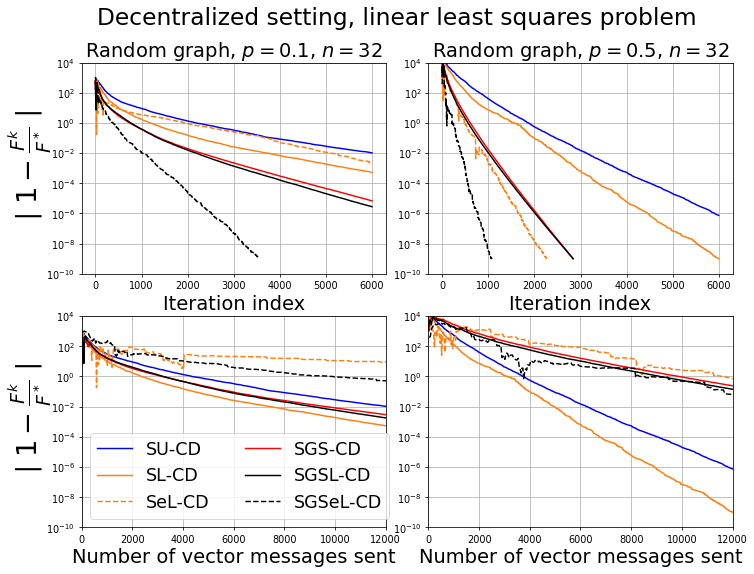

In [16]:

fontsz = {'legends':18, 'axes':20, 'titles':20, 'suptitles':24}

color = {'SU-CD':'blue', 'SGS-CD':'red',
         'SL-CD':'C1', 'SGSL-CD':'black',
         'SeL-CD':'C1', 'SGSeL-CD':'black'}
linestyle = {'SU-CD':'-', 'SGS-CD':'-',
             'SL-CD':'-', 'SGSL-CD':'-',
             'SeL-CD':'--', 'SGSeL-CD':'--'}

"""'''''' Plots ''''''"""

fig, ax = plt.subplots(2, len(G_list), figsize=(12,8), dpi=70)

min_max_comm_sup = [np.infty for i in range(2)]
for i in range(len(G_list)):
    dual_obj_vals = results_dual[i]
    comm_support = results_comm[i]
    for idx_algo, algo in enumerate(algos_to_run):
        suboptim = abs(1 - dual_obj_vals[algo]/opt_vals[i])
        ax[0,i].plot(suboptim, color=color[algo], linestyle=linestyle[algo], label=algo)
        ax[1,i].plot(comm_support[algo], suboptim, color=color[algo], linestyle=linestyle[algo], label=algo)
        if comm_support[algo][-1] < min_max_comm_sup[i]:
            min_max_comm_sup[i] = comm_support[algo][-1]

for i in range(len(G_list)):
    ax[0,i].set_xlabel('Iteration index', fontsize=fontsz['axes'])
    ax[1,i].set_xlabel('Number of vector messages sent', fontsize=fontsz['axes'])
    ax[i,0].set_ylabel(r'$ \mid 1 - \frac{F^k}{F^*} \mid $', fontsize=fontsz['axes']+8)
    ax[i,0].yaxis.set_label_coords(-0.09,0.5)

    ax[1,i].set_xlim((0, min_max_comm_sup[i % 2]))
    ax[0,i].grid()
    ax[1,i].grid()
    ax[0,i].set_yscale("log")
    ax[1,i].set_yscale("log")
    ax[0,i].set_ylim([10e-11, 10e3])
    ax[1,i].set_ylim([10e-11, 10e3])
    title_str = 'Random graph, ' + r'$p = $' + str(p_list[i % 2]) + r', $n = $' + str(n)
    ax[0,i].set_title(title_str, fontsize=fontsz['titles'])

ax[1,0].legend(loc='lower left', ncol=2, fontsize=fontsz['legends'])

suptitle_str = 'Decentralized setting, linear least squares problem'
fig.suptitle(suptitle_str, fontsize=fontsz['suptitles'])

fig.subplots_adjust(
    left  = 0.125,  # the left side of the subplots of the figure
    right = 0.9,    # the right side of the subplots of the figure
    bottom = 0.05,   # the bottom of the subplots of the figure
    top = 0.88,      # the top of the subplots of the figure
    wspace = 0.14,   # the amount of width reserved for blank space between subplots
    hspace = 0.2)   # the amount of height reserved for white space between subplots
